<a href="https://colab.research.google.com/github/aliozanmemeto/Airflow-Tasks/blob/main/ADLR_New_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install h5py

In [43]:
import h5py
with h5py.File("tactmat.h5", 'r') as dataset:
    samples = dataset['samples'][:]
    materials = [m.decode('utf-8') for m in dataset['materials'][:]]

In [48]:
samples.shape

(36, 100, 1000, 4, 4)

In [71]:
import torch

# Creating a tensor of shape (2, 3, 4)
tensor = torch.arange(24).reshape(2, 3, 4)
print("Original Shape:", tensor.shape)
print(tensor)

Original Shape: torch.Size([2, 3, 4])
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])


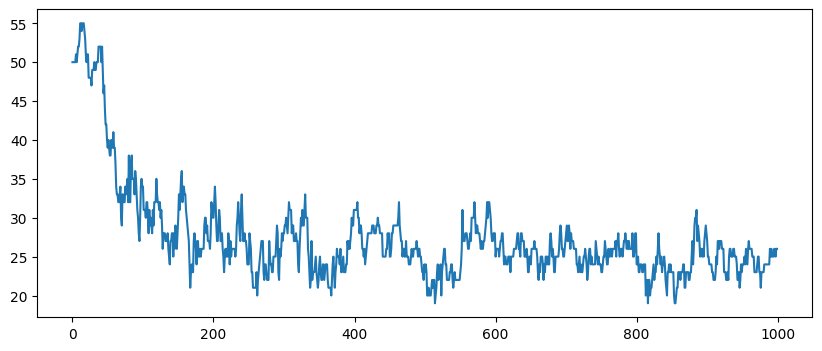

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(samples[7, 5, :1000, 1, 1])

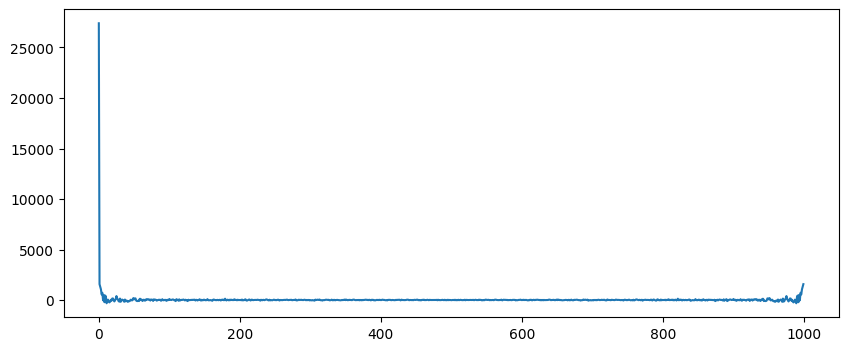

In [66]:
samples_ff = np.fft.fft(samples[7, 5, :1000, 1, 1])

plt.figure(figsize=(10, 4))
plt.plot(samples_ff.real)

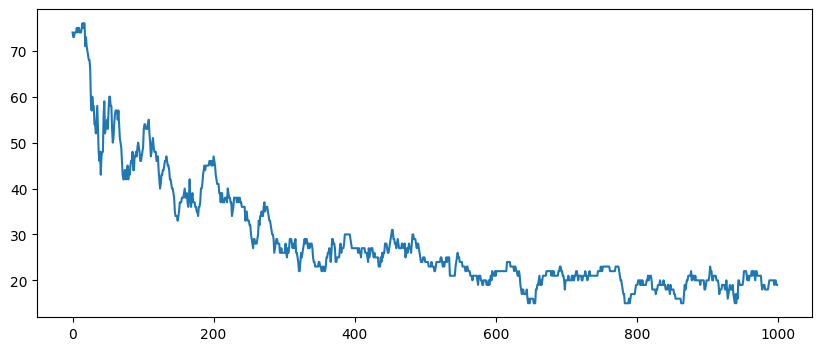

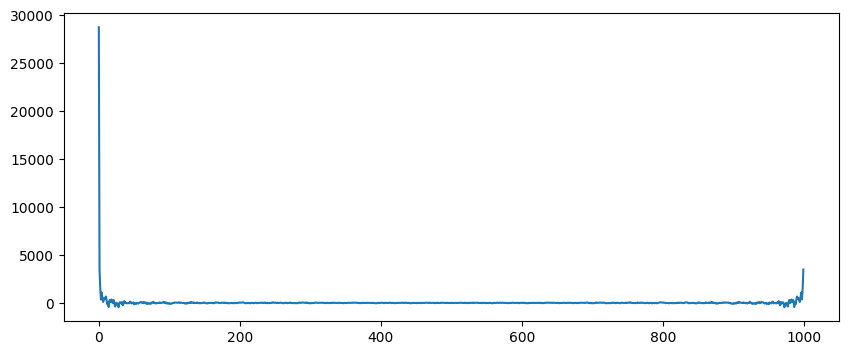

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(samples[10, 5, :1000, 1, 1])

samples_ff = np.fft.fft(samples[10, 5, :1000, 1, 1])

plt.figure(figsize=(10, 4))
plt.plot(samples_ff.real)

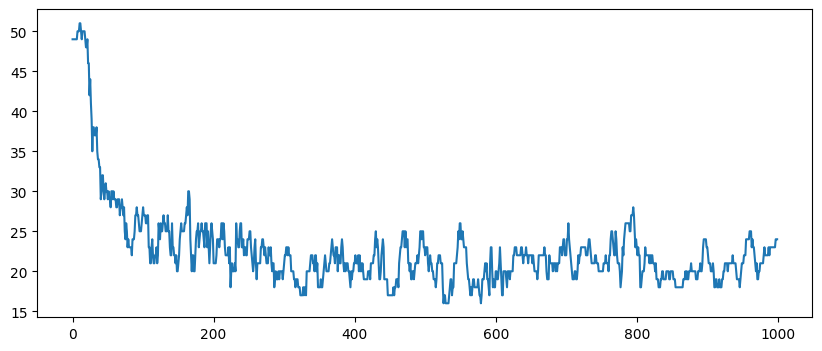

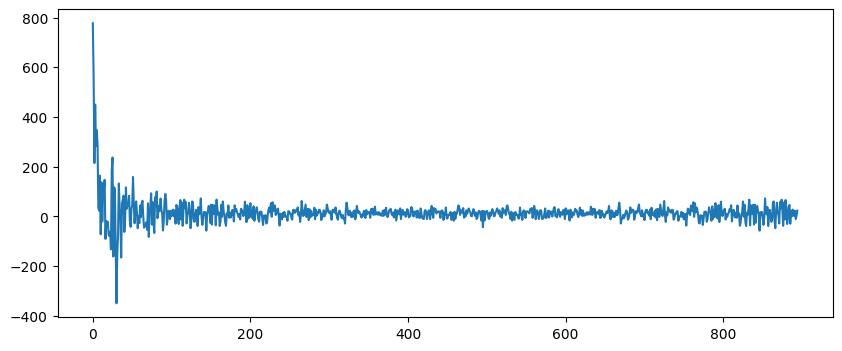

In [80]:
plt.figure(figsize=(10, 4))
plt.plot(samples[22, 80, :1000, 1, 1])

samples_ff = np.fft.fft(samples[22, 80, :1000, 1, 1])

plt.figure(figsize=(10, 4))
plt.plot(samples_ff.real[5:900])

In [39]:
import jax.numpy as np
from jax import random

(-2.0, 2.0)

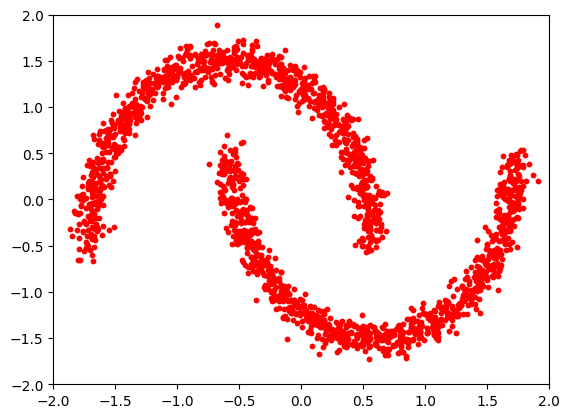

In [40]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

In [41]:
rng = random.PRNGKey(0)

In [78]:
def sample_n01(N):
  D = 16
  return random.normal(rng, (N, D))

def log_prob_n01(x):
  return np.sum(-np.square(x)/2 - np.log(np.sqrt(2*np.pi)),axis=-1)

(array([  3.,  73., 410., 496., 189., 108., 103., 109., 157., 352.]),
 array([-3.86054468, -3.66542673, -3.47030878, -3.27519083, -3.08007288,
        -2.88495493, -2.68983674, -2.49471879, -2.29960084, -2.10448289,
        -1.90936494]),
 <BarContainer object of 10 artists>)

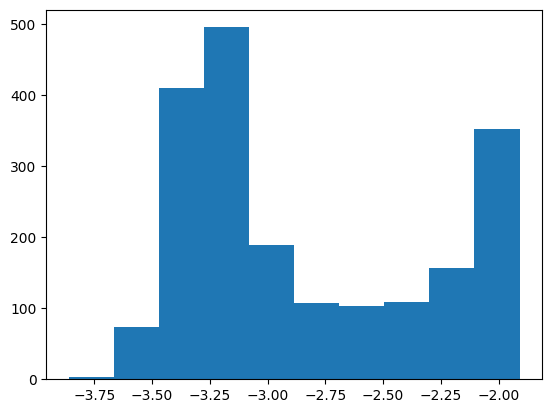

In [43]:
plt.hist(log_prob_n01(X))

In [22]:
from jax.example_libraries import stax # neural network library
from jax.example_libraries.stax import Dense, Relu # neural network layers

In [44]:
def nvp_forward(net_params, shift_and_log_scale_fn, x, flip=False):
  d = x.shape[-1]//2
  x1, x2 = x[:, :d], x[:, d:]
  if flip:
    x2, x1 = x1, x2
  shift, log_scale = shift_and_log_scale_fn(net_params, x1)
  y2 = x2*np.exp(log_scale) + shift
  if flip:
    x1, y2 = y2, x1
  y = np.concatenate([x1, y2], axis=-1)
  return y

In [25]:
!pip install tensorflow-probability

In [45]:
def nvp_inverse(net_params, shift_and_log_scale_fn, y, flip=False):
  d = y.shape[-1]//2
  y1, y2 = y[:, :d], y[:, d:]
  if flip:
    y1, y2 = y2, y1
  shift, log_scale = shift_and_log_scale_fn(net_params, y1)
  x2 = (y2-shift)*np.exp(-log_scale)
  if flip:
    y1, x2 = x2, y1
  x = np.concatenate([y1, x2], axis=-1)
  return x, log_scale

In [46]:
def init_nvp():
  D = 16
  net_init, net_apply = stax.serial(
    Dense(512), Relu, Dense(512), Relu, Dense(D))
  in_shape = (-1, D//2)
  out_shape, net_params = net_init(rng, in_shape)
  def shift_and_log_scale_fn(net_params, x1):
    s = net_apply(net_params, x1)
    return np.split(s, 2, axis=1)
  return net_params, shift_and_log_scale_fn

def sample_nvp(net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
  x = base_sample_fn(N)
  return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

def log_prob_nvp(net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
  x, log_scale = nvp_inverse(net_params, shift_log_scale_fn, y, flip=flip)
  ildj = -np.sum(log_scale, axis=-1)
  return base_log_prob_fn(x) + ildj

In [47]:
def init_nvp_chain(n=2):
  flip = False
  ps, configs = [], []
  for i in range(n):
    p, f = init_nvp()
    ps.append(p), configs.append((f, flip))
    flip = not flip
  return ps, configs

def sample_nvp_chain(ps, configs, base_sample_fn, N):
  x = base_sample_fn(N)
  for p, config in zip(ps, configs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  return x

def make_log_prob_fn(p, log_prob_fn, config):
  shift_log_scale_fn, flip = config
  return lambda x: log_prob_nvp(p, shift_log_scale_fn, log_prob_fn, x, flip=flip)

def log_prob_nvp_chain(ps, configs, base_log_prob_fn, y):
  log_prob_fn = base_log_prob_fn
  for p, config in zip(ps, configs):
    log_prob_fn = make_log_prob_fn(p, log_prob_fn, config)
  return log_prob_fn(y)

In [48]:
ps, cs = init_nvp_chain(4)
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

(array([ 15.,  73., 233., 351., 364., 163.,  96., 122., 166., 417.]),
 array([-4.38411093, -4.12691975, -3.8697288 , -3.61253786, -3.35534668,
        -3.09815574, -2.84096456, -2.58377361, -2.32658243, -2.06939149,
        -1.81220043]),
 <BarContainer object of 10 artists>)

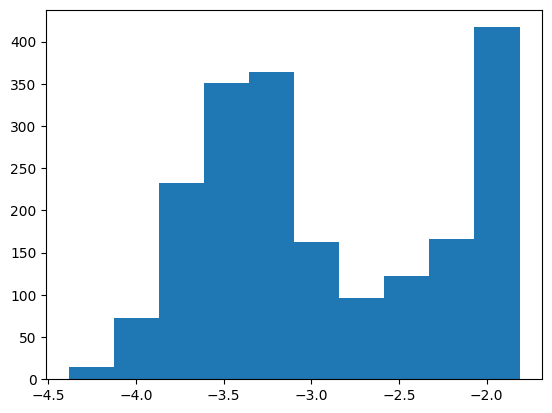

In [49]:
plt.hist(log_prob_nvp_chain(ps, cs, log_prob_n01, X))

In [75]:
from jax.example_libraries import optimizers
from jax import jit, grad
import numpy as onp
from tqdm import tqdm

ps, cs = init_nvp_chain(4)

def loss(params, batch):
  return -np.mean(log_prob_nvp_chain(params, cs, log_prob_n01, batch))
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

@jit
def step(i, opt_state, batch):
  params = get_params(opt_state)
  g = grad(loss)(params, batch)
  return opt_update(i, g, opt_state)

iters = int(1e4)
data_generator = (X[onp.random.choice(X.shape[0], 100)] for _ in range(iters))
opt_state = opt_init(ps)
for i in tqdm(range(iters)):
  opt_state = step(i, opt_state, next(data_generator))
ps = get_params(opt_state)

  2%|▏         | 236/10000 [00:05<03:50, 42.32it/s]


KeyboardInterrupt: 

In [77]:
data_generator = (X[onp.random.choice(X.shape[0], 100)] for _ in range(iters))

for batch in data_generator:
    print(batch.shape)

(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(

KeyboardInterrupt: 

In [68]:
onp.random.choice(X.shape[0], 100).shape

(100,)

In [52]:
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

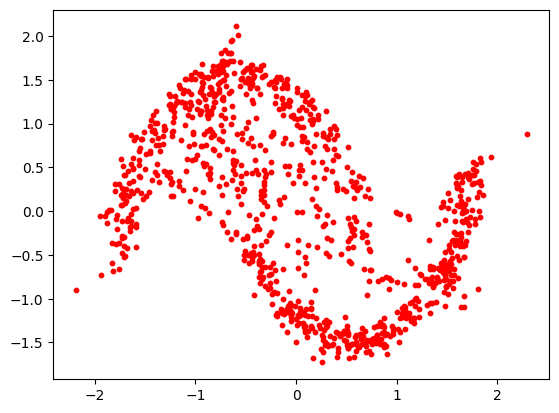

In [53]:
plt.scatter(y[:, 0], y[:, 1], s=10, color='red')
xlim, ylim = [-3, 3], [-3, 3]

In [54]:
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [55]:
x = sample_n01(1000)
values = [x]
for p, config in zip(ps, cs):
  shift_log_scale_fn, flip = config
  x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  values.append(x)

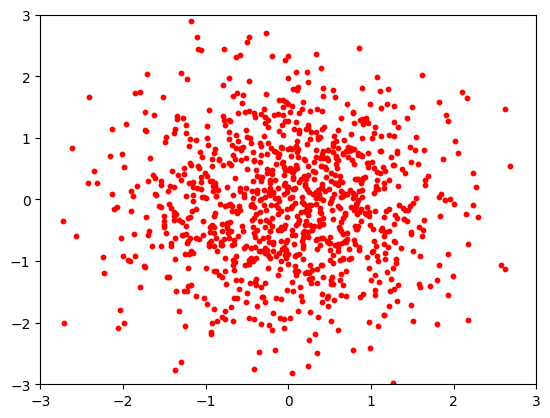

In [56]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

y = values[0]
paths = ax.scatter(y[:, 0], y[:, 1], s=10, color='red')

In [57]:
def animate(i):
  l = i//48
  t = (float(i%48))/48
  y = (1-t)*values[l] + t*values[l+1]
  paths.set_offsets(y)
  return (paths,)

In [58]:
anim = animation.FuncAnimation(fig, animate, frames=48*len(cs), interval=1, blit=False)

In [59]:
anim.save('anim2.gif', writer='imagemagick', fps=60)

In [60]:
Image(url='anim2.gif')